In [1]:
import MetaTrader5 as mt5
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
if not mt5.initialize():
    print("Failed initialization")
    quit()

else:
    print("Connected to MT5")

Connected to MT5


In [3]:
# Fetch Historical Data

symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_H1
rates = mt5.copy_rates_range(
    symbol,
    timeframe,
    datetime(2025, 10, 1),
    datetime(2025, 11, 1)
)

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")
df.set_index("time", inplace=True)
df = df[["open", "high", "low", "close", "tick_volume"]]
print(f"Loaded {len(df)} bars of data for {symbol}")

Loaded 552 bars of data for EURUSD


In [4]:
# Compute SMAs

df["SMA9"] = df["close"].rolling(window=9).mean()
df["SMA21"] = df["close"].rolling(window=21).mean()

df.dropna(inplace=True)

In [5]:
# Generate Signals

df["signal"] = 0
df.loc[df["SMA9"] > df["SMA21"], "signal"] = 1
df.loc[df["SMA9"] < df["SMA21"], "signal"] = -1
df["position_change"] = df["signal"].diff()


In [6]:
# Backtesting simulation

initial_balance = 10000
balance = initial_balance
position = 0
entry_price = 0
balance_history = []

for i in range(len(df)):
    price = df["close"].iloc[i]
    signal = df["signal"].iloc[i]
    change = df["position_change"].iloc[i]

    # Entry
    if change == 2:
        entry_price = price
        position = 1
    elif change == -2:
        entry_price = price
        position = -1

    # P/L tracking

    if position == 1:
        pnl = price - entry_price
    elif position == -1:
        pnl = entry_price - price
    else:
        pnl = 0

    balance_history.append(initial_balance + pnl)

df["equity"] = balance_history


In [7]:
# Calculate Strategy Performance

df["return"] = df["close"].pct_change()
df["strategy_return"] = df["signal"].shift(1) * df["return"]
cumulative_strategy = (1 + df["strategy_return"]).cumprod()

total_return = (cumulative_strategy.iloc[-1] - 1) * 100
print(f"Strategy total return: {total_return: .2f}%")

Strategy total return: -0.79%


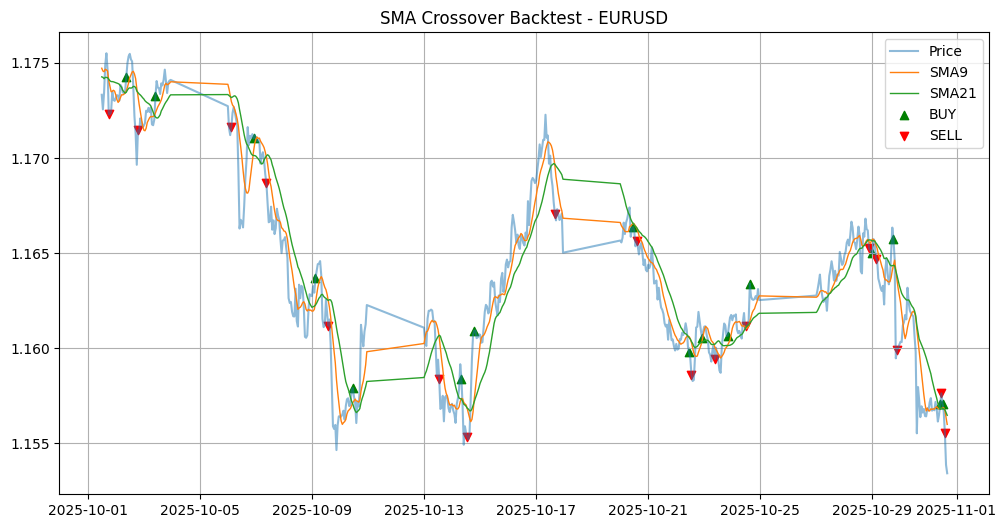

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["close"], label="Price", alpha=0.5)
plt.plot(df.index, df["SMA9"], label="SMA9", linewidth=1)
plt.plot(df.index, df["SMA21"], label="SMA21", linewidth=1)

plt.scatter(df.index[df["position_change"] == 2], df["close"][df["position_change"] == 2],
            label="BUY", marker="^", color="green")
plt.scatter(df.index[df["position_change"] == -2], df["close"][df["position_change"] == -2],
           label="SELL", marker="v", color="red")

plt.title("SMA Crossover Backtest - EURUSD")
plt.legend()
plt.grid(True)
plt.show()


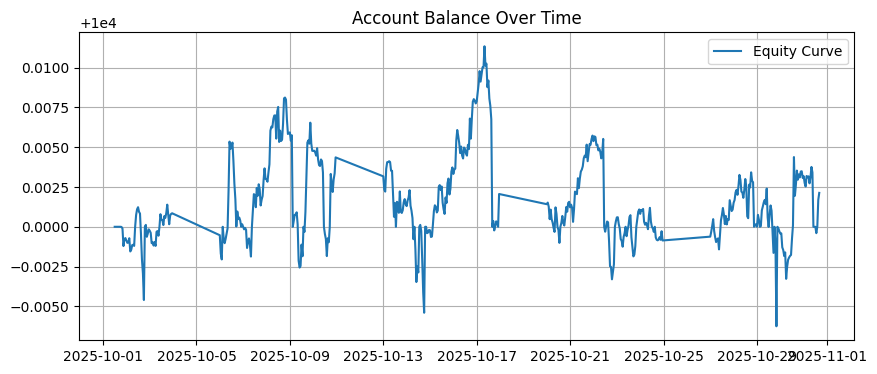

In [9]:
# Plot Equity Curve

plt.figure(figsize=(10, 4))
plt.plot(df["equity"], label="Equity Curve")
plt.title("Account Balance Over Time")
plt.legend()
plt.grid(True)
plt.show()